# Viele Dateien

**Inhalt:** Massenverarbeitung von gescrapten Zeitreihen

**Nötige Skills:** Daten explorieren, Time+Date Basics

**Lernziele:**
- Pandas in Kombination mit Scraping
- Öffnen und zusammenfügen von vielen Dateien (Glob)
- Umstrukturierung von Dataframes (Pivot)
- Plotting Level 4 (Small Multiples)

## Das Beispiel

Wir interessieren uns in diesem Notebook für Krypto-Coins.

Die Webseite https://cryptocompare.com/ führt Marktdaten zu den wichtigsten Coins auf.

Via API beschaffen wir uns die Daten zu den 30 grössten davon:
- Erklär-Artikel: https://towardsdatascience.com/obtaining-historical-and-real-time-crypto-data-with-very-simple-web-programming-7b481f153630
- Dokumentation: https://min-api.cryptocompare.com/documentation

Der Pfad zum Projektordner heisst `dataprojects/Krypto/`. Dort ist auch der Scraper abgelegt.

Zu jeder Kryptowährung haben wir ein csv-Datenfile im Unterordner `data/`.

## Vorbereitung

In [154]:
import pandas as pd

In [155]:
import numpy as np

In [156]:
import re

In [157]:
import glob

## Daten laden

**In diesem Teil hat es einige neue Funktionen drin, die wir noch nicht kennen. Sie können sich einfach durchklicken.**

### Übersicht über die Währungen

In diesem File sind die 100 grössten Kryptowährungen nach Marktkapitalisierung abgelegt. Es dient hier nur als Referenz, wir arbeiten nicht weiter damit.

In [158]:
df_currencies = pd.read_csv("dataprojects/Krypto/100_currencies_new.csv")

Die 30 grössten davon, zu denen wir die Daten haben:

In [159]:
df_currencies.head(30)

,id,name,fullname,internal,marketcap
0,1182,BTC,Bitcoin,BTC,5.019685e+11
1,7605,ETH,Ethereum,ETH,1.945722e+11
2,171986,USDT,Tether,USDT,8.630609e+10
3,5031,XRP,XRP,XRP,4.961426e+10
4,204788,BNB,Binance Coin,BNB,3.358295e+10
5,925809,USDC,USD Coin,USDC,2.615091e+10
6,938193,STETH,Staked Ether,STETH,1.390870e+10
7,321992,ADA,Cardano,ADA,1.116450e+10
8,934443,SOL,Solana,SOL,1.012722e+10
9,925144,OKB,OKB,OKB,9.818342e+09


### Einlesen 1: ein einzelnes File

Zu jeder Kryptowährung gibt es eine Datei mit den Kursdaten. Wir laden testweise eines davon:

In [160]:
path = 'dataprojects/Krypto/'

In [161]:
df = pd.read_csv(path + 'data/BTC.csv')

In [162]:
df.head(2)

,date,open,high,low,close,volume,currency
0,2018-09-10,6249.07,6371.42,6247.64,6324.43,3.204353e+08,Bitcoin
1,2018-09-11,6324.43,6415.51,6199.19,6295.54,3.245129e+08,Bitcoin


In [163]:
df.tail(2)

,date,open,high,low,close,volume,currency
1825,2023-09-09,25907.13,25937.07,25797.25,25898.41,1.059249e+08,Bitcoin
1826,2023-09-10,25898.41,25900.68,25716.83,25768.05,8.467718e+07,Bitcoin


Das DF ist 1827 Einträge lang (das entspricht 1 Eintrag pro Tag während 5 Jahren)

In [164]:
len(df)

1827

Theoretisch könnten wir diesen Code jetzt für jede der 100 Währungen manuell wiederholen.

Doch das ist umständlich, wir wollen automatisch alle Währungen laden.

### Einlesen 2: Alle Files auf einmal

**Schritt 1: Liste von Dateinamen erstellen**

Wir starten damit, dass wir das Verzeichnis durchsuchen, in dem alle Kryptowährungs-Daten abgelegt sind.

Dazu benutzen wir `glob`, ein praktisches Tool aus der Standard Library: https://docs.python.org/3/library/glob.html

In [165]:
filenames = glob.glob(path + 'data/*.csv')

Check: Anzahl der Files

In [166]:
len(filenames)

30

Wir haben nun eine Liste von allen Dateinamen. Die ersten zwei Einträge sind:

In [167]:
filenames[0:2]

['dataprojects/Krypto/data/ARB.csv', 'dataprojects/Krypto/data/OP.csv']

**Schritt 2: Liste von Dataframes anhand der Dateinamen**

Nun lesen wir jede einzelne Datei aus der Liste ein - und zwar in eine **Liste von Dataframes**.

Diese Liste nennen wir `dfs[]`. Sie wird so viele Einträge haben wie es Währungen gibt, jedes davon ein Dataframe.

In [168]:
dfs = []

Zum Einlesen benutzen wir list comprehension...

In [169]:
dfs = [pd.read_csv(filename) for filename in filenames]

In [170]:
dfs[0].head(2)

,date,open,high,low,close,volume,currency
0,2018-09-10,0.0,0.0,0.0,0.0,0.0,Arbitrum
1,2018-09-11,0.0,0.0,0.0,0.0,0.0,Arbitrum


**Schritt 4: Die DFs untereinander in ein einziges DF reihen**

Nun fügen wir alle Dataframes zu einem einzigen, sehr langen Dataframe zusammen.

Dazu benutzen wir die Funktion `pd.concat()`: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html

In [171]:
df_all = pd.concat(dfs, ignore_index=True)

Das resultierende DF ist nun 30x länger als die einzelnen zuvor:

In [172]:
df_all.shape

(54810, 7)

In [173]:
df_all.head(2)

,date,open,high,low,close,volume,currency
0,2018-09-10,0.0,0.0,0.0,0.0,0.0,Arbitrum
1,2018-09-11,0.0,0.0,0.0,0.0,0.0,Arbitrum


In [174]:
df_all.tail(2)

,date,open,high,low,close,volume,currency
54808,2023-09-09,0.5437,0.5437,0.5391,0.5393,1892501.22,Polygon
54809,2023-09-10,0.5393,0.5394,0.5158,0.5202,5496958.77,Polygon


In [175]:
df_all.dtypes

date         object
open        float64
high        float64
low         float64
close       float64
volume      float64
currency     object
dtype: object

Wir haben nun ein ellenlanges Dataframe. What next?

### Daten arrangieren

Das hängt davon ab, was wir mit den Daten genau tun wollen.

Eine Option wäre: die verschiedenen Währungen miteinander zu vergleichen. 
- Welche Währung hat vom Tag X zum Tag Y wie stark zugelegt?

Dazu müssen wir das Dataframe zunächst umstellen, mit `pivot()`: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pivot.html

In [176]:
df_pivoted = df_all.pivot(index='date', columns='currency', values='close')

Mit `pivot()` haben wir folgendes gemacht:
- Statt im "Long"-Format sind die Daten nun im "Wide"-Format
- Das heisst in diesem Fall: Wir haben es anhand der Währungen rearrangiert (`columns='currency'`)
- Die Währungen stehen jetzt nicht mehr *untereinander*, sondern *nebeneinander*
- Die Info, die wir für jede Währung ausgewählt haben, ist der Schlusskurs `values='Close'`)
- Das DF ist jetzt wieder nur noch 366 Zeilen lang.
- Index jeder Zeile ist ein Datum (`index='date'`)

In [177]:
df_pivoted.shape

(1827, 30)

In [178]:
df_pivoted.head(2)

currency,Aptos,Arbitrum,Avalanche,Binance Coin,Binance USD,Bitcoin,Bitcoin Cash,Cardano,Chainlink,Dai,...,Solana,Staked Ether,Stellar,TRON,Tether,True USD,USD Coin,Uniswap Protocol Token,Wrapped Bitcoin,XRP
date,,,,,,,,,,,,,,,,,,,,,
2018-09-10,0.0,0.0,0.0,9.575,0.0,6324.43,466.17,0.07500,0.2486,1.001,...,0.0,0.0,0.1906,0.01923,1.002,1.002,0.0,0.0,0.000569,0.2697
2018-09-11,0.0,0.0,0.0,9.368,0.0,6295.54,439.87,0.06952,0.2625,1.001,...,0.0,0.0,0.1995,0.01850,1.001,1.001,0.0,0.0,0.000692,0.2630


Nun verfügen wir über einen Index, bei dem eine Zeile jeweils einem einzigartigen Zeitpunkt entspricht.

Wir verschönern die Indexspalte noch etwas:

In [179]:
df_pivoted.rename_axis(None, inplace=True)

In [180]:
df_pivoted.head(2)

currency,Aptos,Arbitrum,Avalanche,Binance Coin,Binance USD,Bitcoin,Bitcoin Cash,Cardano,Chainlink,Dai,...,Solana,Staked Ether,Stellar,TRON,Tether,True USD,USD Coin,Uniswap Protocol Token,Wrapped Bitcoin,XRP
2018-09-10,0.0,0.0,0.0,9.575,0.0,6324.43,466.17,0.07500,0.2486,1.001,...,0.0,0.0,0.1906,0.01923,1.002,1.002,0.0,0.0,0.000569,0.2697
2018-09-11,0.0,0.0,0.0,9.368,0.0,6295.54,439.87,0.06952,0.2625,1.001,...,0.0,0.0,0.1995,0.01850,1.001,1.001,0.0,0.0,0.000692,0.2630


Für ein sauberes Dataframe müssen wir noch alle 0-Werte mit "nan" ersetzen:

In [181]:
df_pivoted = df_pivoted.replace(0, np.nan)

Wir haben nun ein sauber formatiertes Dataframe, das für jede Kryptowährung, sofern sie zum betreffenden Zeitpunkt existierte, einen Handelskurs enthält.

**Grossartig! Wir sind damit bereit für die Datenanalyse. Ab hier sind Sie an der Reihe...**

## Analyse

### Vorbereitung

Remember: Mit welchem Typ von Daten haben wir es hier zu tun...?

In [182]:
df_pivoted.index

Index(['2018-09-10', '2018-09-11', '2018-09-12', '2018-09-13', '2018-09-14',
       '2018-09-15', '2018-09-16', '2018-09-17', '2018-09-18', '2018-09-19',
       ...
       '2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
       '2023-09-06', '2023-09-07', '2023-09-08', '2023-09-09', '2023-09-10'],
      dtype='object', length=1827)

... genau: mit einer Zeitreihe.

Um damit zu arbeiten, müssen wir den Text in der Indexspalte in ein echtes Datum umwandeln.

In [183]:
df_pivoted.index = pd.to_datetime(df_pivoted.index)

Und wir müssen den Datums-Index aufsteigend sortieren.

In [184]:
df_pivoted.sort_index(inplace=True)

In [185]:
df_pivoted.head(2)

currency,Aptos,Arbitrum,Avalanche,Binance Coin,Binance USD,Bitcoin,Bitcoin Cash,Cardano,Chainlink,Dai,...,Solana,Staked Ether,Stellar,TRON,Tether,True USD,USD Coin,Uniswap Protocol Token,Wrapped Bitcoin,XRP
2018-09-10,NaN,NaN,NaN,9.575,NaN,6324.43,466.17,0.07500,0.2486,1.001,...,NaN,NaN,0.1906,0.01923,1.002,1.002,NaN,NaN,0.000569,0.2697
2018-09-11,NaN,NaN,NaN,9.368,NaN,6295.54,439.87,0.06952,0.2625,1.001,...,NaN,NaN,0.1995,0.01850,1.001,1.001,NaN,NaN,0.000692,0.2630


Die nächste Frage ist: Wie vergleichen wir diese Kurse? Was sagt es aus, wenn eine Währung an einem bestimmten Tag zu 0,1976 USD gehandelt wurde und eine andere zu 18,66 USD?

### Vergleichbarkeit herstellen

Diverse Dinge würden sich hier anbieten:
- zB `pct_change()` um die Veränderungen in den Kursen zu analysieren
- oder eine indexierte Zeitreihe, die an einem bestimmten Tag bei 100 beginnt

Wir wählen die zweite Variante.

Wählen Sie einen bestimmten Tag X: Dieser Tag ist das Startdatum für den Vergleich.

In [186]:
# Beispiel: 1 Jahr bevor die Daten enden
day_x = "2022-09-10"

Wie lesen Sie die entsprechende Zeile aus dem Dataframe für diesen Tag aus?

In [187]:
row_x = df_pivoted.loc[day_x]

Dann teilen wir jede einzelne Zeile im Dataframe durch die Tag-X-Zeile und multiplizieren sie mit 100. Speichern wir das Ergebnis als neues DF ab.

In [188]:
df_pivoted_100 = df_pivoted / row_x * 100

Das neue Dataframe müsste nun indexiert auf 100 sein: Alle Währungen starten am gleichen Punkt.

Stimmt das wirklich? Schauen Sie sich den Tag X an, um sicher zu sein...

In [189]:
df_pivoted_100[day_x:day_x]

currency,Aptos,Arbitrum,Avalanche,Binance Coin,Binance USD,Bitcoin,Bitcoin Cash,Cardano,Chainlink,Dai,...,Solana,Staked Ether,Stellar,TRON,Tether,True USD,USD Coin,Uniswap Protocol Token,Wrapped Bitcoin,XRP
2022-09-10,NaN,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


### Auswertung

Jetzt wählen wir einen Tag Y für den Endzeitpunkt der Auswertung.

In [190]:
day_y = "2023-09-10"

Wenn wir uns das DF an diesem Tag anschauen, wissen wir, wie sich die Kurse der Währungen verändert haben.

In [191]:
df_pivoted_100.loc[day_y]

currency
Aptos                            NaN
Arbitrum                         NaN
Avalanche                  46.666667
Binance Coin               71.647626
Binance USD                99.970000
Bitcoin                   118.992821
Bitcoin Cash              142.181023
Cardano                    48.428655
Chainlink                  76.071835
Dai                        99.969994
Dogecoin                   94.699428
Ethereum                   91.203534
LEO Token                  78.147700
Litecoin                   96.099795
Monero                     90.601218
OKB                       253.102190
Optimism                   90.915645
Polkadot                   53.201337
Polygon                    57.410882
Shiba Inu                  55.388093
Solana                     51.882487
Staked Ether               94.225369
Stellar                   113.687881
TRON                      120.799876
Tether                     99.990000
True USD                   99.949985
USD Coin                  100

Wir speichern diese Zeile in einer neuen Series und subtrahieren 100 - so erhalten wir die prozentuale Veränderung.

In [192]:
s_y = df_pivoted_100.loc[day_y] - 100

Welche zehn Kryptowährungen haben am meisten Wert gewonnen?

In [193]:
s_y.sort_values(ascending=False).head(10)

currency
OKB                153.102190
Bitcoin Cash        42.181023
XRP                 38.825175
TRON                20.799876
Wrapped Bitcoin     19.023527
Bitcoin             18.992821
Stellar             13.687881
USD Coin             0.000000
Tether              -0.010000
Binance USD         -0.030000
Name: 2023-09-10 00:00:00, dtype: float64

Welche haben am wenigsten Wert gewonnen (bzw. am meisten verloren)?

In [194]:
s_y.sort_values(ascending=False, na_position='first').tail(10)

currency
LEO Token                -21.852300
Chainlink                -23.928165
Binance Coin             -28.352374
Uniswap Protocol Token   -37.039257
Polygon                  -42.589118
Shiba Inu                -44.611907
Polkadot                 -46.798663
Solana                   -48.117513
Cardano                  -51.571345
Avalanche                -53.333333
Name: 2023-09-10 00:00:00, dtype: float64

### Plots

Erstellen Sie einen einfachen Linienplot mit den relativen Kursen aller Währungen (Start bei 100).

<Axes: title={'center': 'Relative Entwicklung der Kurse'}>

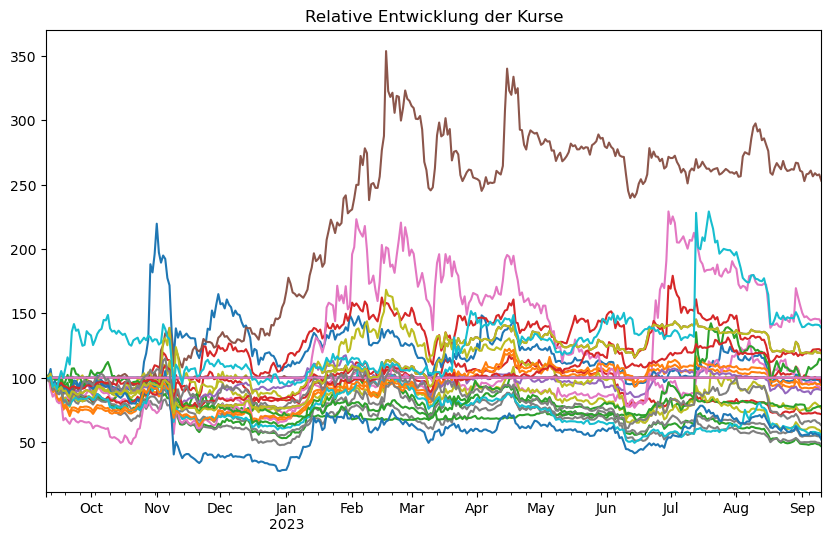

In [213]:
df_pivoted_100[day_x:day_y].plot(figsize=(10,6), legend=False, title='Relative Entwicklung der Kurse')

Wow, das sind ziemlich viele Linien! Beschränken wir uns mal auf die Kryptowährungen, für die wir effektiv durchgehend Daten haben:

In [196]:
firstline = df_pivoted_100.loc['2018-09-10']

In [197]:
valid_currencies = firstline[~firstline.isnull()].index

In [198]:
valid_currencies

Index(['Binance Coin', 'Bitcoin', 'Bitcoin Cash', 'Cardano', 'Chainlink',
       'Dai', 'Dogecoin', 'Ethereum', 'Litecoin', 'Monero', 'OKB', 'Stellar',
       'TRON', 'Tether', 'True USD', 'Wrapped Bitcoin', 'XRP'],
      dtype='object', name='currency')

Sie können die Spalten im Dataframe mit den relativen Kursen nun anhand dieser Liste filtern.

In [199]:
df_pivoted_100[valid_currencies]

currency,Binance Coin,Bitcoin,Bitcoin Cash,Cardano,Chainlink,Dai,Dogecoin,Ethereum,Litecoin,Monero,OKB,Stellar,TRON,Tether,True USD,Wrapped Bitcoin,XRP
2018-09-10,3.226839,29.205228,351.322632,14.639859,3.144050,100.120024,10.819039,11.111800,86.057161,67.104262,8.132603,166.172624,29.694256,100.20,100.230069,0.000003,75.440559
2018-09-11,3.157079,29.071818,331.501997,13.570174,3.319843,100.120024,9.956730,10.432808,82.125375,66.717402,7.512165,173.931997,28.567017,100.10,100.130039,0.000003,73.566434
2018-09-12,3.103158,29.263782,326.045670,12.859653,3.217402,100.020004,9.964457,10.313351,81.667456,65.994419,7.335766,171.665214,28.072884,100.00,100.130039,0.000003,75.496503
2018-09-13,3.231557,29.979040,350.064059,13.913722,3.465284,100.220044,10.063360,11.904614,86.104532,71.061644,7.542579,179.598954,30.589870,100.10,100.430129,0.000004,78.125874
2018-09-14,3.335692,29.951379,337.568769,13.593598,3.355255,99.989998,9.449853,11.769379,88.915206,73.959919,7.366180,175.501308,30.574429,100.00,99.789937,0.000003,77.258741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-06,72.517103,118.916765,145.459341,50.283037,79.650942,100.010002,98.300108,91.979444,99.242065,90.131913,256.569343,108.020924,121.865349,99.97,99.869961,118.916731,140.755245
2023-09-07,73.204597,121.294354,145.903987,50.361117,80.751233,100.000000,98.331015,92.840440,100.584241,90.988077,259.002433,109.328684,122.050649,100.00,100.020006,121.088316,141.286713
2023-09-08,72.318269,119.635070,145.587459,49.619364,79.435943,100.020004,98.408283,92.192439,98.847308,91.254439,257.360097,110.549259,122.235948,99.98,99.899970,119.515528,141.230769
2023-09-09,72.163246,119.594803,145.497023,49.424166,77.968888,99.919984,97.929223,92.144544,99.557871,90.943683,258.029197,114.734089,122.251390,99.98,99.939982,119.475301,140.895105


Plotten Sie nun ausschliesslich die Entwicklung der ausgewählten Währungen.

<Axes: title={'center': 'Relative Entwicklung der Kurse'}>

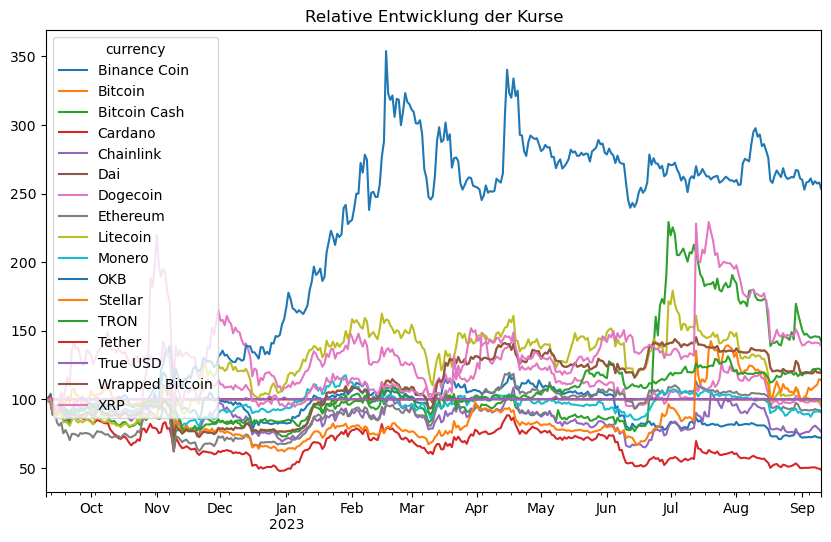

In [214]:
df_pivoted_100[valid_currencies][day_x:day_y].plot(figsize=(10,6), legend=True, title='Relative Entwicklung der Kurse')

Was fällt Ihnen auf?

In [201]:
# Die meisten Währungen verlaufen parallel
# Einzelne verhalten sich ganz anders (zB Tether, ein Stablecoin)

Daten exportieren

In [215]:
#df_pivoted_100[valid_currencies].to_csv(path + 'Close_indexed_to_100.csv')

# Plotting Level 4

**Hier geht es wieder gemütlicher zu und her - Sie können sich durchklicken und müssen nichts programmieren.**

Inhalt dieser Plotting-Lektion:

- Wir lernen, wie "Small Multiples" geht
- Wir sehen, wie man die matplotlib-Funktionen direkt benutzen kann.

Dazu importieren wir erstmal ein paar Libraries...

In [216]:
import matplotlib.pyplot as plt

In [217]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

... und laden eine Datei, welche das Ergebnis der bisherigen Übung enthält (die relativen Kurse aller Währungen - normalisiert zum Tag X).

In [218]:
df_relative = pd.read_csv(path + 'Close_indexed_to_100.csv', index_col=0)
df_relative.index = pd.to_datetime(df_relative.index)

In [219]:
df_relative.head()

,Binance Coin,Bitcoin,Bitcoin Cash,Cardano,Chainlink,Dai,Dogecoin,Ethereum,Litecoin,Monero,OKB,Stellar,TRON,Tether,True USD,Wrapped Bitcoin,XRP
2018-09-10,3.226839,29.205228,351.322632,14.639859,3.144050,100.120024,10.819039,11.111800,86.057161,67.104262,8.132603,166.172624,29.694256,100.2,100.230069,0.000003,75.440559
2018-09-11,3.157079,29.071818,331.501997,13.570174,3.319843,100.120024,9.956730,10.432808,82.125375,66.717402,7.512165,173.931997,28.567017,100.1,100.130039,0.000003,73.566434
2018-09-12,3.103158,29.263782,326.045670,12.859653,3.217402,100.020004,9.964457,10.313351,81.667456,65.994419,7.335766,171.665214,28.072884,100.0,100.130039,0.000003,75.496503
2018-09-13,3.231557,29.979040,350.064059,13.913722,3.465284,100.220044,10.063360,11.904614,86.104532,71.061644,7.542579,179.598954,30.589870,100.1,100.430129,0.000004,78.125874
2018-09-14,3.335692,29.951379,337.568769,13.593598,3.355255,99.989998,9.449853,11.769379,88.915206,73.959919,7.366180,175.501308,30.574429,100.0,99.789937,0.000003,77.258741


### Ein Plot

Starten wir zuerst mal mit einem Plot: Bitcoin.

Technisch gesehen besteht jede Matplotlib-/Pandas-Grafik aus zwei Dingen:
1. Eine "figure", also eine Abbildung, gewissermassen das Blatt Papier
1. Ein "subplot", also der einzelne Plot selbst, pro "Papier" können es auch mehrere sein

<Axes: title={'center': 'Bitcoin'}>

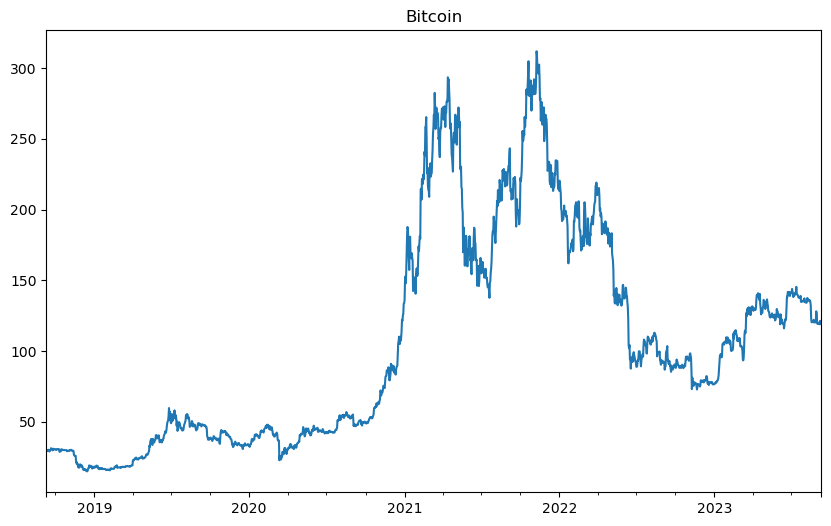

In [220]:
# Wir erstellen beide Dinge in einem Atemzug: figure und subplot
fig, ax = plt.subplots(figsize=(10,6))

# Und füllen den Plot jetzt mit Inhalt:
df_relative['Bitcoin'].plot(title="Bitcoin", ax=ax)

### Zwei Plots

Als nächstes Plotten wir zwei Währungen auf derselben Figure: Bitcoin und Ethereum.

Wir müssen uns dazu erneut zwei Dinge basteln:
1. Eine "figure", also eine Abbildung
1. Diverse "subplots" für die jeweiligen Währungen

Dazu formatieren wir jetzt die x-Achse etwas speziell.

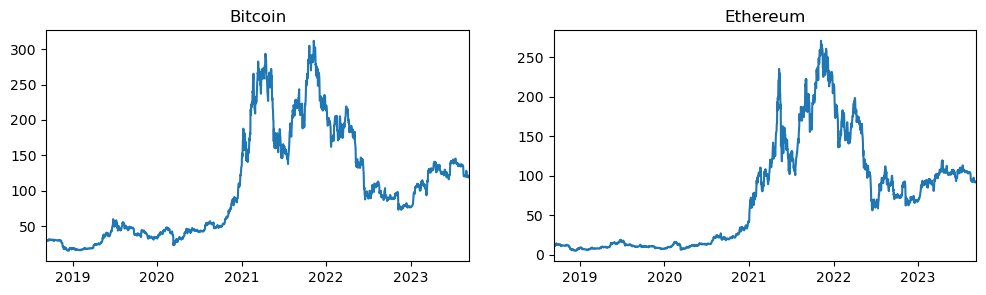

In [221]:
# Zuerst kreieren wir nur die Figure
fig = plt.figure(figsize=(12,3))

# Danach die einzelnen Subplots
ax1 = fig.add_subplot(1, 2, 1) # total 1 Zeile, total 2 Spalten, Subplot Nr. 1
ax2 = fig.add_subplot(1, 2, 2) # total 1 Zeile, total 2 Spalten, Subplot Nr. 2

# Und schliesslich füllen wir die Subplots mit Inhalt
df_relative['Bitcoin'].plot(title="Bitcoin", ax=ax1)
df_relative['Ethereum'].plot(title="Ethereum", ax=ax2)

# Hier formatieren wir die x-Achse für Plot 1
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(ticker.NullLocator())

# Hier formatieren wir die x-Achse für Plot 2
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_minor_locator(ticker.NullLocator())

Einige Angaben dazu, wie man Zeitachsen formatieren kann, gibt es hier:
- TickLocators: https://matplotlib.org/examples/ticks_and_spines/tick-locators.html
- TickFormatters: https://matplotlib.org/gallery/ticks_and_spines/tick-formatters.html

### Sehr viele Plots

Nun plotten wir sämtliche Währungen, die keine "NaN"-Werte enthalten, auf einmal.

Dazu isolieren wir erst kurz die letzte Zeile.

In [222]:
s_last = df_relative.iloc[-1]

Wie viele Währungen sind nicht "NaN"?

In [223]:
anzahl_charts = s_last.notnull().sum()
anzahl_charts

17

Wir sortieren unsere Liste der Währungen anhand der letzten Zeile etwas:

In [224]:
sortierte_waehrungen = s_last[s_last.notnull()].sort_values(ascending=False)
sortierte_waehrungen.head(2)

OKB             253.102190
Bitcoin Cash    142.181023
Name: 2023-09-10 00:00:00, dtype: float64

Und wiederholen dann wiederum dasselbe Vorgehen wie vorher.

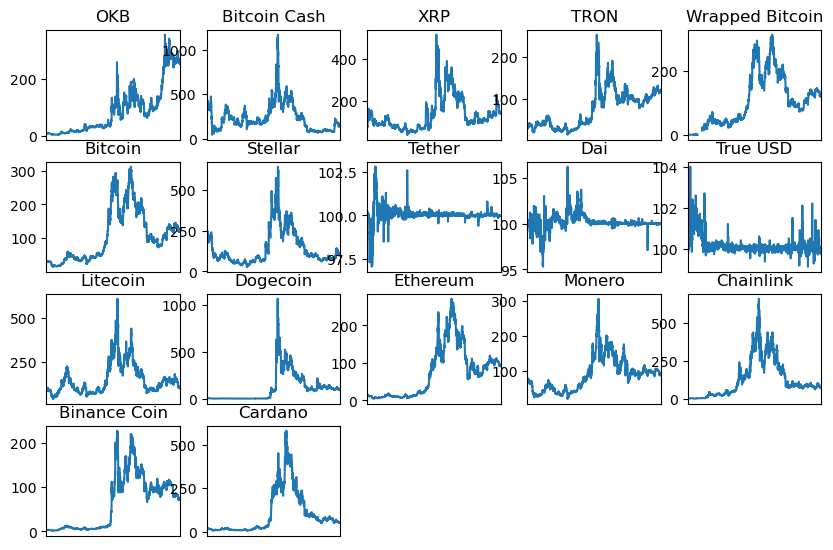

In [225]:
# Eine Abbildung, die gross genug ist
fig = plt.figure(figsize=(10,10))

# Und nun, für jede einzelne Währung einen Subplot:
for i, waehrung in enumerate(sortierte_waehrungen.index):
    
    # einen Subplot kreieren ... ()
    ax = fig.add_subplot(6, 5, i + 1)

    # ... und mit Inhalt füllen
    df_pivoted_100[waehrung].plot(title=waehrung, ax=ax)
    
    # Auf Ticks verzichten wir hier ganz
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.NullLocator())

Falls wir zusätzlich noch wollen, dass jeder Plot dieselbe y-Achse hat:

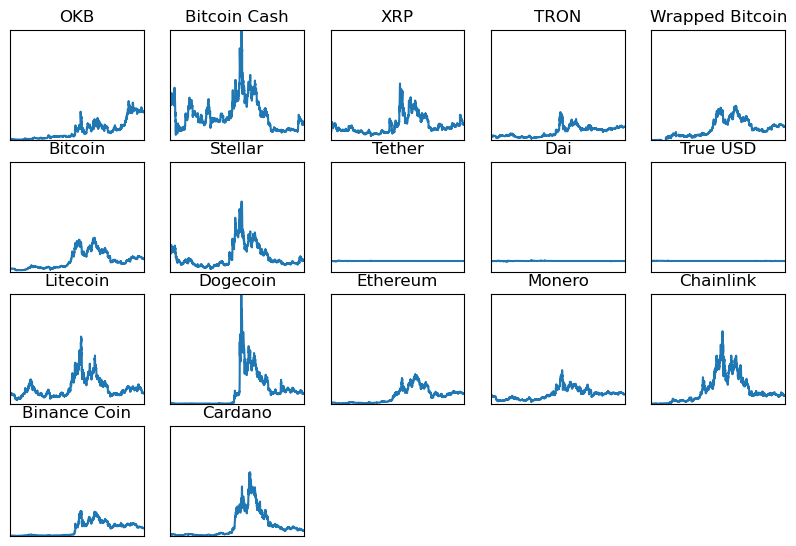

In [226]:
# Eine Abbildung, die gross genug ist
fig = plt.figure(figsize=(10, 10))

# Und nun, für jede einzelne Währung:
for i, waehrung in enumerate(sortierte_waehrungen.index):
    
    # einen Subplot kreieren ...
    ax = fig.add_subplot(6,5, i + 1)

    # ... und mit Inhalt füllen
    df_pivoted_100[waehrung].plot(title=waehrung, ax=ax)
    
    # Auf Ticks verzichten wir hier ganz
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    
    # Hier setzen wir eine einheitliche y-Achse (und schalten sie aus)
    ax.set_ylim([0, 1000])
    ax.yaxis.set_major_locator(ticker.NullLocator())

### Aber es geht auch einfacher...

Ha! Nachdem wir nun alles Manuell zusammengebastelt haben, mit Matplotlib, hier die gute Nachricht:

*Wir können das mit wenigen Codezeilen auch direkt aus der Pandas-Plot()-Funktion haben :-)*

Die entscheidenden Parameter in der `plot()`-Funktion sind hier:
- `subplots=True` (zeichnet small multiples statt alles nur auf einem Chart)
- `sharey=True` (alle Subplots sollen dieselbe y-Achse verwenden)

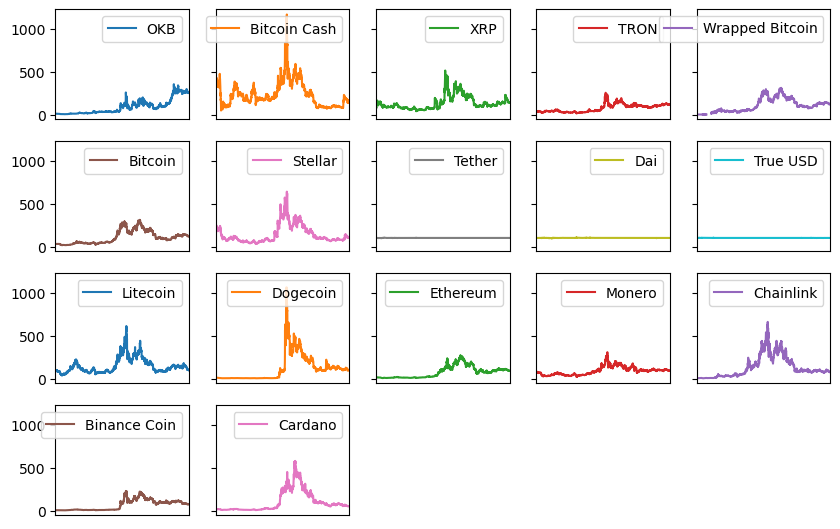

In [227]:
axes = df_pivoted_100[sortierte_waehrungen.index].plot(subplots=True,layout=(6, 5), sharey=True, figsize=(10, 10))

axes[0,0].xaxis.set_major_locator(ticker.NullLocator())
axes[0,0].xaxis.set_minor_locator(ticker.NullLocator())

# Übung

**In dieser letzten Sektion haben Sie nochmals Gelegenheit, alles zu üben – Daten arrangieren, analysieren, plotten**

Hier schauen wir uns nicht mehr die Handelskurse, sondern die Handelsvolumen an! Also: Wie viel von den einzelnen Kryptowährungen an einem bestimmten Tag gekfauft und verkauft wurde (gemessen in USD).

Schauen Sie sich nochmals das Dataframe `df_all` an, das wir im Verlauf des Notebooks erstellt haben - es enthält alle Informationen, die wir brauchen, ist aber noch relativ unstrukturiert.

In [228]:
df_all.tail(2)

,date,open,high,low,close,volume,currency
54808,2023-09-09,0.5437,0.5437,0.5391,0.5393,1892501.22,Polygon
54809,2023-09-10,0.5393,0.5394,0.5158,0.5202,5496958.77,Polygon


Welche Spalte interessiert uns? Müssen wir noch etwas daran machen?

In [229]:
# Uns interessiert die Spalte "volume"

### Daten arrangieren

Nun wollen wir die Daten umgliedern:
- Für jedes Datum wollen wir eine Zeile
- Für jede Kryptowährung eine Spalte
- Wir interessieren uns für die Handelsvolumen

In [230]:
df_pivoted2 = df_all.pivot(index='date', columns='currency', values='volume')

In [231]:
df_pivoted2.head(2)

currency,Aptos,Arbitrum,Avalanche,Binance Coin,Binance USD,Bitcoin,Bitcoin Cash,Cardano,Chainlink,Dai,...,Solana,Staked Ether,Stellar,TRON,Tether,True USD,USD Coin,Uniswap Protocol Token,Wrapped Bitcoin,XRP
date,,,,,,,,,,,,,,,,,,,,,
2018-09-10,0.0,0.0,0.0,4455759.85,0.0,3.204353e+08,8.989306e+07,6042.93,183892.29,50736.55,...,0.0,0.0,1656039.59,191047.01,50806.82,297885.52,0.0,0.0,49.05,29176231.97
2018-09-11,0.0,0.0,0.0,6276262.63,0.0,3.245129e+08,1.025502e+08,3027.92,293600.72,51434.55,...,0.0,0.0,3041698.32,277615.26,51432.67,412158.62,0.0,0.0,29.93,22046487.85


Formatieren Sie die Werte in der Index-Spalte als Datetime-Objekte und sortieren Sie das Dataframe nach Datum.

In [232]:
df_pivoted2.rename_axis(None, inplace=True)

In [233]:
df_pivoted2.index = pd.to_datetime(df_pivoted.index, format="%b %d, %Y")

In [234]:
df_pivoted2.sort_index(inplace=True)

Ersetzen Sie schliesslich alle 0-Werte durch nan-Werte

In [235]:
df_pivoted2 = df_pivoted2.replace(0, np.nan)

### Analyse

Wir machen in dieser Sektion einige einfache Auswertungen und repetieren einige Befehle, u.a. aus dem Time Series Sheet.

**Top-10**: Welches waren, im Schnitt, die zehn meistgehandelten Währungen? Liste und Chart.

In [236]:
df_pivoted2.mean().sort_values(ascending=False).head(10)

currency
Bitcoin         9.828895e+08
Ethereum        7.245462e+08
Solana          1.539474e+08
Litecoin        1.195687e+08
Arbitrum        1.143582e+08
Aptos           8.001494e+07
XRP             7.383768e+07
Bitcoin Cash    6.693656e+07
Optimism        6.679328e+07
Binance Coin    5.992328e+07
dtype: float64

<Axes: ylabel='currency'>

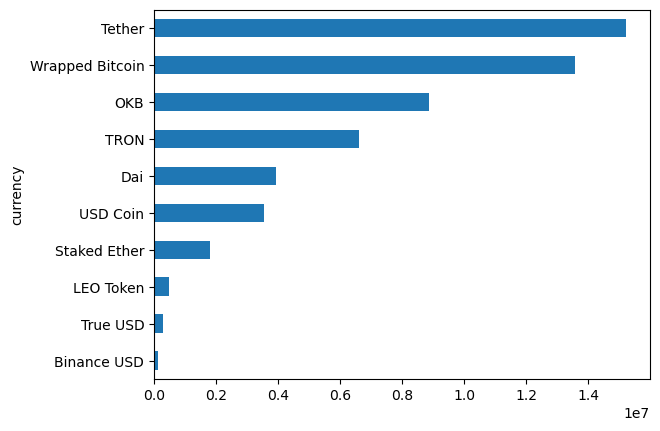

In [237]:
df_pivoted2.mean().sort_values().head(10).plot(kind='barh')

Welches waren die zehn Währungen, bei denen das Volumen in absoluten Zahlen am meisten geschwankt ist? (Standardabweichung)

<Axes: ylabel='currency'>

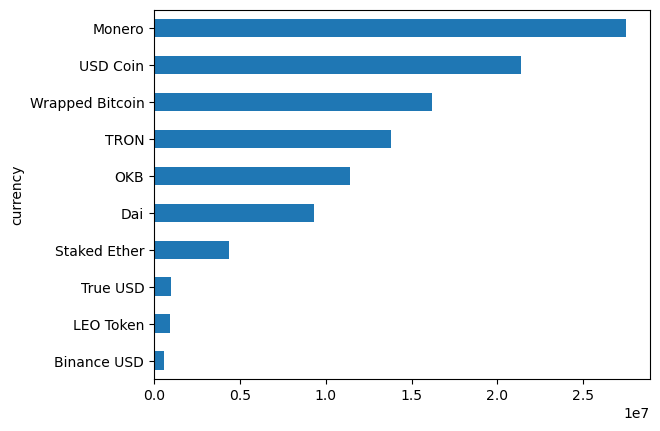

In [238]:
df_pivoted2.std().sort_values().head(10).plot(kind='barh')

**Bitcoin vs Ethereum**

Erstellen Sie einen Chart mit dem wöchentlichen Umsatztotal von Bitcoin und Ethereum!

Tipp: Resampling benutzen!

<Axes: >

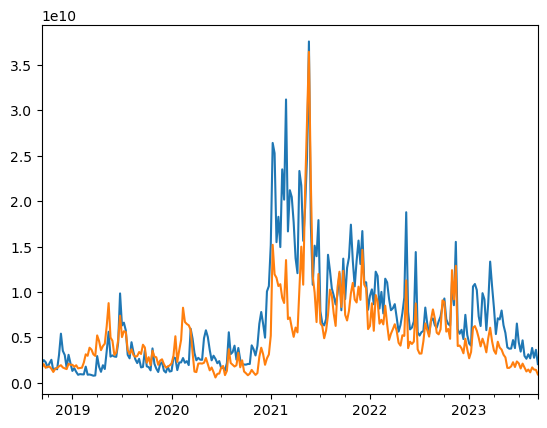

In [239]:
df_pivoted2['Bitcoin'].resample('W').sum().plot()
df_pivoted2['Ethereum'].resample('W').sum().plot()

In welchem der letzten 12 Monate wurde insgesamt am meisten mit Bitcoin gehandelt? Mit Ethereum?

In [240]:
df_pivoted2['Bitcoin'].resample('MS').sum().sort_values(ascending=False).head(1)

2021-05-01    1.037900e+11
Name: Bitcoin, dtype: float64

In [241]:
df_pivoted2['Ethereum'].resample('MS').sum().sort_values(ascending=False).head(1)

2021-05-01    1.129096e+11
Name: Ethereum, dtype: float64

Wie viel Bitcoin und Ethereum wird im Durchschnitt an den sieben Wochentagen gehandelt? Barchart.

<Axes: >

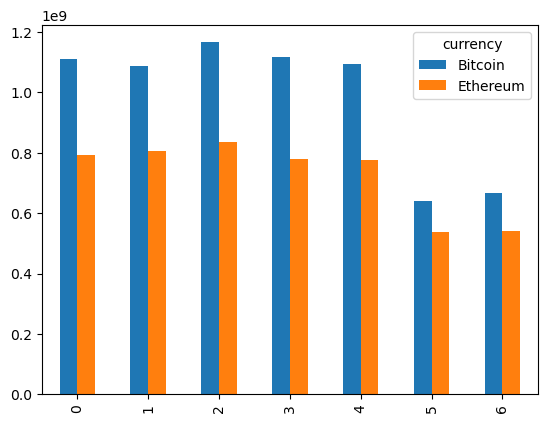

In [242]:
df_pivoted2[['Bitcoin', 'Ethereum']].groupby(df_pivoted2.index.weekday).mean().plot(kind='bar')

**Small Multiples**: Hier erstellen wir einen Plot, ähnlich wie oben

Kreieren Sie zuerst eine Liste von Währungen:
- Alle Währungen, die am letzten Handelstag einen Eintrag haben
- Sortiert in absteigender Reihenfolge nach dem Handelsvolumen
- Wir wählen nur die zehn grössten aus

In [243]:
sortierte_waehrungen = df_pivoted2.iloc[-1].sort_values(ascending=False).head(10)

In [244]:
len(sortierte_waehrungen)

10

In [245]:
sortierte_waehrungen

currency
Bitcoin        84677182.40
Ethereum       67289121.33
Tether         50771706.76
Solana         25214381.85
Binance USD    19408249.93
Stellar        10669194.82
Dogecoin        8135230.00
Litecoin        7687871.68
Cardano         5511013.26
Polygon         5496958.77
Name: 2023-09-10 00:00:00, dtype: float64

Und jetzt: Small Multiples plotten! Überlegen Sie sich:
- Wie viele Subplots braucht es, wie sollen sie angeordnet sein?
- Wie gross muss die Abbildung insgesamt sein?
- Was ist eine sinnvolle Einstellung für die Y-Achse?

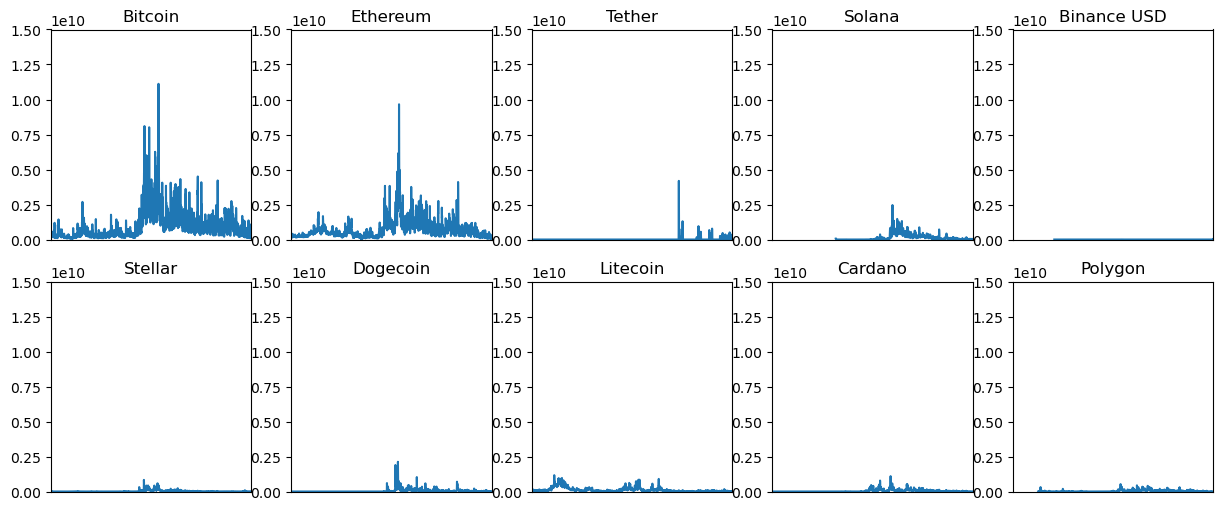

In [246]:
# Eine Abbildung, die gross genug ist
fig = plt.figure(figsize=(15,6))

# Und nun, für jede einzelne Währung:
for i, waehrung in enumerate(sortierte_waehrungen.index):
    
    # einen Subplot kreieren ...
    ax = fig.add_subplot(2, 5, i + 1)

    # ... und mit Inhalt füllen
    df_pivoted2[waehrung].plot(title=waehrung, ax=ax)
    
    # Auf Ticks verzichten wir hier ganz
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    
    ax.set_ylim([0, 1.5e10])

Alternative syntax dafür:

(0.0, 15000000000.0)

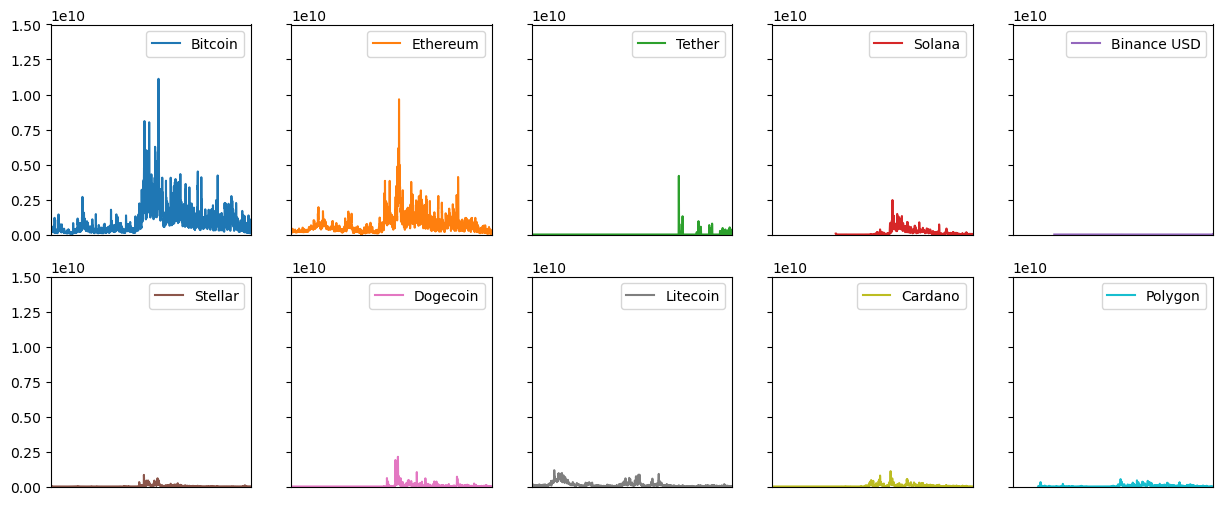

In [247]:
axes = df_pivoted2[sortierte_waehrungen.index].plot(subplots=True,layout=(2,5), sharey=True, figsize=(15,6))

axes[0,0].xaxis.set_major_locator(ticker.NullLocator())
axes[0,0].xaxis.set_minor_locator(ticker.NullLocator())
axes[0,0].set_ylim([0, 1.5e10])